In [ ]:
import pickle as pkl
import numpy as np
import pandas as pd
import os
import torch
import tensorflow as tf
from tensorflow import keras
from torch.utils.data import Dataset, DataLoader,TensorDataset
import torch.nn.functional as F
from sklearn.metrics import f1_score as F1S
import torch.nn as nn
from torch import optim
import copy
import matplotlib.pyplot as plt
import scipy.signal as sp
import scipy.ndimage as mor

In [ ]:
class DilatedResidualLayer(nn.Module):
    def __init__(self, dilation, in_channels, out_channels):
        super(DilatedResidualLayer, self).__init__()
        self.conv_dilated = nn.Conv1d(in_channels, out_channels, 3, padding=dilation, dilation=dilation)
        self.conv_1x1 = nn.Conv1d(out_channels, out_channels, 1) #这一层的作用在于整合不同channel(filters)之间的信息
        self.dropout = nn.Dropout()

    def forward(self, x):
        # print("DilatedResidualLayer")
        out = F.relu(self.conv_dilated(x))
        out = self.conv_1x1(out)
        out = self.dropout(out)
        return (x + out)
class SingleStageModel(nn.Module):
    def __init__(self, num_layers, num_f_maps, dim, num_classes):
        super(SingleStageModel, self).__init__()
        self.conv_1x1 = nn.Conv1d(dim, num_f_maps, 1)  #dim=channel数目 num_f_maps=filter数目
        self.layers = nn.ModuleList([copy.deepcopy(DilatedResidualLayer(2 ** i, num_f_maps, num_f_maps)) for i in range(num_layers)])
        self.conv_out = nn.Conv1d(num_f_maps, num_classes, 1)


    def forward(self, x):
        out = self.conv_1x1(x)
        for layer in self.layers:
            out = layer(out)
        out = self.conv_out(out) 
        return out
class MultiStageModel(nn.Module):
    def __init__(self, num_stages, num_layers, num_f_maps, dim, num_classes):
        super(MultiStageModel, self).__init__()
        self.stage1 = SingleStageModel(num_layers, num_f_maps, dim, num_classes)
        self.stages = nn.ModuleList([copy.deepcopy(SingleStageModel(num_layers, num_f_maps, num_classes, num_classes)) for s in range(num_stages-1)])

    def forward(self, x):
        out = self.stage1(x)
        outputs = out.unsqueeze(0)
        for s in self.stages:
            # print("out dimension",out.shape)      #[3,2,2000]
            # print("the pre out before softmax is ",out[0,:,1997])
            out = s(F.softmax(out, dim=1))    
            outputs = torch.cat((outputs, out.unsqueeze(0)), dim=0)
            # print("the pre out is after softmax is ",out[0,:,1997])
        return outputs
def gaussian_filter1d(size,sigma):
  filter_range = np.linspace(-int(size/2),int(size/2),size)
  gaussian_filter = [1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-x**2/(2*sigma**2)) for x in filter_range]
  return gaussian_filter
def getTPLength(start,end):
  counter=0
  for oneElement in result_Final[start:end]:
    if oneElement ==1:
      counter = counter+1
  return counter
    #check out the IOU scorce
def checkMealIOU(validationPersonId):
  tpCounter=0
  counter11=0
  foundBite_startTime_set = set()
  for oneBiteRange in resultBiteRangeList:
    counter11=counter11+1
    preStart =oneBiteRange[0]
    preEnd =oneBiteRange[1]
    # print(oneBiteRange)
    for oneGTIndex in range(len(annoList[validationPersonId])):
      startTime = annoList[validationPersonId][oneGTIndex][0]
      endTime = annoList[validationPersonId][oneGTIndex][1]
      # print(startTime,"===",endTime)
      if(preStart <= endTime and preEnd>= startTime and not (startTime in foundBite_startTime_set)):
        Intersection = min(preEnd,endTime) - max(preStart,startTime)
        Union = max(preEnd,endTime) - min(preStart,startTime)
        IOU = Intersection/Union
        if IOU > 0.1:
          foundBite_startTime_set.add(startTime)
          tpCounter=tpCounter+1 
          # print(preStart,preEnd)
          # print(tpCounter,oneGTIndex,len(resultBiteList),counter11,oneMidBite,startTime,endTime)
          break
  #计算recall
  Recall = tpCounter/(len(annoList[validationPersonId]))
  #计算precision
  Precision = tpCounter/(len(resultBiteRangeList))
  #计算F1
  F1 = 2/((1/Precision)+(1/Recall))
  print(tpCounter,Recall,Precision,F1)
  listResult =[tpCounter,len(annoList[validationPersonId]),len(resultBiteRangeList),Recall,Precision,F1]
  return listResult


In [ ]:
with open('./drive/MyDrive/TensorflowData/semester2/Final/FinalDataSet/annoLabel48.pkl', 'rb') as fh:
  annoLabel = pkl.load(fh)
with open('./drive/MyDrive/TensorflowData/semester2/Final/FinalDataSet/dataset48.pkl', 'rb') as fh:
  dataset = pkl.load(fh)
with open('./drive/MyDrive/TensorflowData/semester2/Final/FinalDataSet/FreeFIC26R.pkl','rb') as fh:
    datasetFreeR = pkl.load(fh)
with open('./drive/MyDrive/TensorflowData/semester2/Final/FinalDataSet/FreeFIC26L.pkl','rb') as fh:
    datasetFreeL = pkl.load(fh)
with open('./drive/MyDrive/TensorflowData/semester2/Final/FinalDataSet/annoList48.pkl','rb') as fh:
    annoList = pkl.load(fh)

In [ ]:
# validationList=[ [0,1,0] , [2,3,1],[4,5,2],[6,7,3],[8,9,4],[10,11,5],[12,13,6],[14,14,7],[15,15,8],[16,17,9], [18,19,10] , [20,20,11] ,[21,21,12] ,[22,23,13],[24,25,14],[26,27,15] ]
# validationList = [ [16,17,9], [18,19,10] , [20,20,11] ,[21,21,12] ,[22,23,13],[24,25,14],[26,27,15] ]
validationList = [ [0,1,0],[2,3,1],[4,5,2],[6,7,3],[8,9,4],[10,11,5],[12,13,6],[14,14,7],[15,15,8],[16,17,9], [18,19,10] , [20,20,11] ,[21,21,12] ,[22,23,13],[24,25,14],[26,27,15],[44,45,16],[28,29,17],[30,30,18],[40,41,19],[32,33,20],[34,35,21],[36,37,22],[42,43,23],[39,39,24],[46,47,25] ]
validationList = [[46,47,25]]


In [ ]:
with open('./drive/MyDrive/TensorflowData/semester2/Final/FinalDataSet/IndexMapping_FreeFICRange48.pkl', "rb") as fh:   #Pickling
    mapping = pkl.load(fh)
print(mapping[0])

['1-1-1' 4951.0 5946.0 0 0]


In [ ]:
print(len(annoList))

48


In [ ]:
pd.set_option('max_rows', 500000)

resultList = list()
totalTP = 0
totalGT =0
totalPre=0
totalIntersection=0
totalUnion=0
totalIOU=0

modelMode=1 #0:train model 1:load saved model
resultSavedList = list()
for oneDay in validationList:
  validationPersonId1= oneDay[0]
  validationPersonId2= oneDay[1]

  for personId in range(48):
    if personId ==validationPersonId1 or personId ==validationPersonId2:
    # if personId ==validationPersonId or  personId ==1  or personId ==2 or personId ==3 or personId ==5 or personId ==8 or personId ==9 or personId ==10 or personId ==11 or personId ==12:
      continue
    datasetPer = dataset[personId]
    # datasetPer=datasetPer.to_numpy()
    datasetPer=datasetPer[:,0:8]
    datasetPer=datasetPer.astype(np.float32)
    print("meal id is",personId,datasetPer.shape)

    (datasetPer) = tf.keras.preprocessing.timeseries_dataset_from_array(datasetPer[:,0:8],targets=None,sequence_length=2000,sequence_stride=1000,batch_size=None,sampling_rate=3) 

    if personId == 0:
      datasetTotal = datasetPer
    elif (validationPersonId1==0 and personId==2):
      datasetTotal = datasetPer
    else:
      datasetTotal = datasetTotal.concatenate(datasetPer)
  Sequence_data = list()
  Sequence_label=list()
  for oneSequence in datasetTotal:
    Sequence_data.append(oneSequence[:,1:7])
    x= tf.dtypes.cast(oneSequence[:,7],tf.int64)
    Sequence_label.append(x)
  Sequence_data = tf.convert_to_tensor(Sequence_data)
  Sequence_label = tf.convert_to_tensor(Sequence_label)

  Sequence_data = Sequence_data.numpy()
  Sequence_label = Sequence_label.numpy()
  Sequence_data = torch.from_numpy(Sequence_data)
  Sequence_label =  torch.from_numpy(Sequence_label)

  Sequence_data = torch.swapaxes(Sequence_data,1,2)
  dataset_total = TensorDataset(Sequence_data, Sequence_label)

  dataLoader_train = DataLoader(dataset_total, batch_size=60,drop_last=True,shuffle=True)
  print(len(dataLoader_train))

  # validationPersonId1= 42
  # validationPersonId2= 42#======================================

  datasetPer = dataset[validationPersonId1]
  datasetPer=datasetPer[:,0:8]
  datasetPer=datasetPer.astype(np.float32)
  print("validation meal id is",validationPersonId1,datasetPer.shape)
  (datasetVal) = tf.keras.preprocessing.timeseries_dataset_from_array(datasetPer[:,0:8],targets=None,sequence_length=2000,sequence_stride=6000,batch_size=None,sampling_rate=3) 

  Sequence_data = list()
  Sequence_label=list()
  for oneSequence in datasetVal:
    Sequence_data.append(oneSequence[:,1:7])
    x= tf.dtypes.cast(oneSequence[:,7],tf.int64)
    Sequence_label.append(x)

  Sequence_data = tf.convert_to_tensor(Sequence_data)
  Sequence_label = tf.convert_to_tensor(Sequence_label)
  Sequence_data = Sequence_data.numpy()
  Sequence_label = Sequence_label.numpy()
  Sequence_data = torch.from_numpy(Sequence_data)
  Sequence_label =  torch.from_numpy(Sequence_label)

  Sequence_data = torch.swapaxes(Sequence_data,1,2)
  datasetVal1 = TensorDataset(Sequence_data, Sequence_label)
  datasetPer = dataset[validationPersonId2]
  # datasetPer = datasetPer.numpy()
  datasetPer=datasetPer[:,0:8]
  datasetPer=datasetPer.astype(np.float32)
  print("validation meal id is",validationPersonId2,datasetPer.shape)
  (datasetVal) = tf.keras.preprocessing.timeseries_dataset_from_array(datasetPer[:,0:8],targets=None,sequence_length=2000,sequence_stride=6000,batch_size=None,sampling_rate=3) 

  Sequence_data = list()
  Sequence_label=list()
  for oneSequence in datasetVal:
    Sequence_data.append(oneSequence[:,1:7])
    x= tf.dtypes.cast(oneSequence[:,7],tf.int64)
    Sequence_label.append(x)

  Sequence_data = tf.convert_to_tensor(Sequence_data)
  Sequence_label = tf.convert_to_tensor(Sequence_label)

  Sequence_data = Sequence_data.numpy()
  Sequence_label = Sequence_label.numpy()
  Sequence_data = torch.from_numpy(Sequence_data)
  Sequence_label =  torch.from_numpy(Sequence_label)
  Sequence_data = torch.swapaxes(Sequence_data,1,2)
  datasetVal2 = TensorDataset(Sequence_data, Sequence_label)

  datasetVal= torch.utils.data.ConcatDataset([datasetVal1,datasetVal2])
  dataLoader_val = DataLoader(datasetVal, batch_size=200,drop_last=False,shuffle=True)
  print(len(datasetVal),len(dataLoader_val))
  device = torch.device("cuda")
  loss_ce =nn.CrossEntropyLoss()
  loss_mse = nn.MSELoss(reduction='none')
  loss_mse=loss_mse.to(device)
  #创建模型
  mstcn1 = MultiStageModel(2,10,50,6,2) #第一个是stage个数 第二个是每个stage的层数 第三个是每层filter个数 第四个是input的channel数 第五个是类别数
  mstcn1=mstcn1.to(device)
  learning_rate = 5e-4
  optimizer = optim.RMSprop(mstcn1.parameters(),lr=learning_rate)
  #设置训练参数
  epoch =0
  best_f1Val=0
  if modelMode == 0:
    for i in range(epoch):
        print("--------------------epoch{} start----------------------".format(i+1))
        #遍历该epoch中的每个batch
        epoch_loss=0
        correct=0
        total=0
        mstcn1.train()
        for batch_ndx, sample in enumerate(dataLoader_train):
          # print("batch index is ",batch_ndx)
          oneBatchData= sample[0]
          oneBatchLabel= sample[1]
          oneBatchData=oneBatchData.to(device)
          oneBatchLabel=oneBatchLabel.to(device)

          optimizer.zero_grad()
          predictions = mstcn1(oneBatchData)
          loss=0
          f1_score_train=0
          f1_score_counter=0
          #遍历所有stage的预测算出总loss
          for p in predictions:
            loss += loss_ce(p.transpose(2, 1).contiguous().view(-1, 2), oneBatchLabel.view(-1))
            # loss += los.sigmoid_focal_loss(p.transpose(2, 1).contiguous().view(-1, 1), oneBatchLabel.view(-1,1))
            loss += 0.15*torch.mean(torch.clamp(loss_mse(F.log_softmax(p[:, :, 1:], dim=1), F.log_softmax(p.detach()[:, :, :-1], dim=1)), min=0, max=16))
          epoch_loss += loss.item()
          loss.backward()
          optimizer.step()
          _, predicted = torch.max(predictions[-1].data, 1)   #[30,2,2000] =>max => [30,2000] 这里-1代表最后一层stage的预测输出
          # print("raw predicted p for all classes is", (predictions[-1].data)[0,:,1996],(predictions[-1].data).shape)
          correct += ((predicted == oneBatchLabel).float().squeeze(1)).sum().item()     #prediectd的大小是[30,2000] 放的是类的index 和oneBatchLabel大小完全一样因此可以直接比较
          f1_score_train += F1S(oneBatchLabel.cpu(), predicted.cpu(),average='micro')
          f1_score_counter +=1
          total += 60000      #[30,2000] [batchsize,seqlength]

        print("EPOCH loss is ",epoch_loss )
        print("correct is ",correct)
        print("total is ",total)
        print("acc = %f" % ( float(correct)/total))
        print("f1_score = %f" % ( float(f1_score_train)/f1_score_counter))

        total_val_loss = 0
        correct_val=0
        mstcn1=mstcn1.eval()
        total_val=0
        f1_score_val=0
        f1_score_counter_val=0
        with torch.no_grad():
          for batch_ndx, sample in enumerate(dataLoader_val):
            oneBatchData= sample[0]
            oneBatchLabel= sample[1]
            oneBatchData=oneBatchData.to(device)
            oneBatchLabel=oneBatchLabel.to(device)
            predictions_val = mstcn1(oneBatchData)
            loss_val=0
            for p in predictions_val:
              loss_val += loss_ce(p.transpose(2, 1).contiguous().view(-1, 2), oneBatchLabel.view(-1))
              loss_val += 0.15*torch.mean(torch.clamp(loss_mse(F.log_softmax(p[:, :, 1:], dim=1), F.log_softmax(p.detach()[:, :, :-1], dim=1)), min=0, max=16))
            total_val_loss=total_val_loss+loss_val
            _, predicted_val = torch.max(predictions_val[-1].data, 1)   #[30,2,2000] =>max => [30,2000]
            correct_val += ((predicted_val == oneBatchLabel).float().squeeze(1)).sum().item() 
            f1_score_val += (F1S(oneBatchLabel.cpu(), predicted_val.cpu(),average='micro'))
            f1_score_counter_val += 1
            total_val += 60000
          print("EPOCH loss_val is ",total_val_loss ) 
          print("correct is ",correct_val)
          print("total is ",total_val)
          print("acc = %f" % (   float(correct_val)/total_val))
          print("val_f1_score = %f" % ( float(f1_score_val)/f1_score_counter_val))
          f1_scoreValue=(float(f1_score_val)/f1_score_counter_val)
          Path = "bestModel.pth"
          # PATH = './drive/MyDrive/TensorflowData/semester2/Final/MSTCN_FreeFIC_LOSO/bestModel1_MSTCN_FreeFIC_LOSO' + str(oneDay[2]) +'.pth'
          if f1_scoreValue > best_f1Val:
            best_f1Val = f1_scoreValue
            torch.save(mstcn1.state_dict(),PATH)
            model_dict=torch.load(PATH)
    validationPersonId=oneDay[2]
    datasetPer = datasetFreeR[validationPersonId]
    datasetPer = datasetPer.to_numpy()
    datasetPer=datasetPer[:,0:8]
    datasetPer=datasetPer.astype(np.float32)
    print("validation meal id is",validationPersonId,datasetPer.shape)
    (datasetVal) = tf.keras.preprocessing.timeseries_dataset_from_array(datasetPer[:,0:7],targets=None,sequence_length=2000,sequence_stride=6000,batch_size=None,sampling_rate=3) 
    print(len(datasetVal))
    mstcn1.load_state_dict(torch.load(PATH))
  if modelMode==1:
    PATH = './drive/MyDrive/TensorflowData/semester2/Final/MSTCN_FreeFIC_LOSO/bestModel1_MSTCN_FreeFIC_LOSO' + str(oneDay[2]) +'.pth'
    mstcn1.load_state_dict(torch.load(PATH))
    validationPersonId=oneDay[2]
    datasetPer = datasetFreeR[validationPersonId]
    datasetPer = datasetPer.to_numpy()
    datasetPer=datasetPer[:,0:8]
    datasetPer=datasetPer.astype(np.float32)
    print("validation meal id is",validationPersonId,datasetPer.shape)
    (datasetVal) = tf.keras.preprocessing.timeseries_dataset_from_array(datasetPer[:,0:7],targets=None,sequence_length=2000,sequence_stride=6000,batch_size=None,sampling_rate=3) 
    print(len(datasetVal))
    mstcn1.load_state_dict(torch.load(PATH))

  #with time Column
  result_afterThreshold_list = list()
  time_list= list()
  mstcn1.eval()
  for oneValidationSequence in datasetVal:
      oneValidationSequence = oneValidationSequence.numpy()
      oneValidationSequence = torch.from_numpy(oneValidationSequence)
      oneValidationSequence=np.expand_dims(oneValidationSequence,0)
      input = oneValidationSequence[:,:,1:7]
      input =torch.from_numpy(input)
      input = torch.swapaxes(input,1,2)
      input = input.to(device)
      timeCol = oneValidationSequence[:,:,0]
      predictions = mstcn1(input)
      _, resultCol = torch.max(predictions[-1].data, 1) 
      resultCol=resultCol.to(torch.device('cpu'))
      timeCol=np.moveaxis(timeCol,0,1)
      resultCol = torch.swapaxes(resultCol,0,1)
      sigma1 = 200
      sigma2 = 10
      filter1= gaussian_filter1d(size=60,sigma=sigma2)    #原来是10
      result_afterFiltering= np.convolve(resultCol[:,0],filter1,mode='same')
      result_afterThreshold = np.where(result_afterFiltering > 0.5, 1, 0)       #用于滤掉noise并且整合
      for oneTimestampIndex in range(len(timeCol)):
        result_afterThreshold_list.append(result_afterThreshold[oneTimestampIndex])
        # result_afterThreshold_list.append(resultCol[oneTimestampIndex])
        time_list.append(timeCol[oneTimestampIndex])
  result_R = list()
  result_R = result_afterThreshold_list
#left hand FreeFIC
  datasetPer = datasetFreeL[validationPersonId]
  datasetPer = datasetPer.to_numpy()
  datasetPer=datasetPer[:,0:8]
  datasetPer=datasetPer.astype(np.float32)
  print("validation meal id is",validationPersonId,datasetPer.shape)
  (datasetVal) = tf.keras.preprocessing.timeseries_dataset_from_array(datasetPer[:,0:7],targets=None,sequence_length=2000,sequence_stride=6000,batch_size=None,sampling_rate=3) 
  print(len(datasetVal))
  result_afterThreshold_list = list()
  time_list= list()
  mstcn1.eval()
  for oneValidationSequence in datasetVal:
      oneValidationSequence = oneValidationSequence.numpy()
      oneValidationSequence = torch.from_numpy(oneValidationSequence)
      oneValidationSequence=np.expand_dims(oneValidationSequence,0)

      input = oneValidationSequence[:,:,1:7]
      input =torch.from_numpy(input)
      input = torch.swapaxes(input,1,2)
      input = input.to(device)
      timeCol = oneValidationSequence[:,:,0]
      predictions = mstcn1(input)
      _, resultCol = torch.max(predictions[-1].data, 1) 
      resultCol=resultCol.to(torch.device('cpu'))
      timeCol=np.moveaxis(timeCol,0,1)
      resultCol = torch.swapaxes(resultCol,0,1) 
      filter1= gaussian_filter1d(size=60,sigma=sigma2)    #原来是10
      result_afterFiltering= np.convolve(resultCol[:,0],filter1,mode='same')
      result_afterThreshold = np.where(result_afterFiltering > 0.5, 1, 0)       #用于滤掉noise并且整合
      for oneTimestampIndex in range(len(timeCol)):
        result_afterThreshold_list.append(result_afterThreshold[oneTimestampIndex])
        # result_afterThreshold_list.append(resultCol[oneTimestampIndex])
        time_list.append(timeCol[oneTimestampIndex])
  result_L = list()
  result_L = result_afterThreshold_list
  #左右手取最大值进行拼接
  result_Final = list()
  for index in range(len(result_L)):
    if result_L[index] < result_R[index]:
      result_Final.append(result_R[index])
    else:
      result_Final.append(result_L[index])

  result_Final.extend([0]*1000)
  lastTime = time_list[-1]
  for index in range(1000):
    time_list.append(lastTime+index+1)

  result_Final_closing = mor.binary_closing(result_Final,iterations=2500)  

  flag =0
  counter=0
  begin=0
  end=0
  mealTime=0
  for oneElement in result_Final_closing:
    counter = counter+1
    if oneElement==1 and flag==0:
      flag=1
      begin=counter
    if oneElement ==0 and flag==1:
      flag=0
      end=counter
      mealLength =time_list[end] - time_list[begin]
      if validationPersonId==14 and mealLength<400:
        continue
      if mealLength > 300 :
        num = getTPLength(begin,end)
        density = num/(end-begin)
        if (mealLength<600 and density>0.1) or(600<mealLength<1000 and density>0.05) or (mealLength>1000 and density>0.03):
          resultBiteRangeList= list()
          print(begin,end,time_list[begin],time_list[end])
          print(num,density)
          resultList.append( [time_list[begin],time_list[end],num,num/(end-begin)] )
          mealFlag = 0
          mealCounter =0
          mealStart =0
          mealEnd =0
          for eachMealResult in result_Final[begin:end]:
            if eachMealResult==1 and mealFlag==0:
              mealFlag=1
              mealStart=time_list[mealCounter+begin]
            if eachMealResult==0 and mealFlag==1:
              mealFlag=0
              mealEnd=time_list[mealCounter+begin]
              cycleLength= mealEnd-mealStart
              if cycleLength >1:
                # print([mealStart,mealEnd])
                resultBiteRangeList.append([mealStart,mealEnd])
            mealCounter=mealCounter+1
          # print(len(resultBiteRangeList))
          if mealTime==0:
            # gt_begin = mapping[validationPersonId1][1]
            # gt_end = mapping[validationPersonId1][2]
            gt_begin = min(annoList[validationPersonId1][:,0])
            gt_end = max(annoList[validationPersonId1][:,1])
            InterSection = min(gt_end,time_list[end])-max(gt_begin,time_list[begin])
            Uion = max(gt_end,time_list[end])-min(gt_begin,time_list[begin])
            IOU= InterSection/Uion
            print("IOU score is ",IOU)
            # totalIOU.append(IOU)
            totalIntersection=totalIntersection+InterSection
            totalUnion=totalUnion+Uion
            totalIOU=totalIntersection/totalUnion

            result = checkMealIOU(validationPersonId1)
            totalTP = totalTP+result[0]
            totalGT = totalGT+result[1]
            totalPre = totalPre+ result[2]
            totalRecall = totalTP/totalGT
            totalPrecision = totalTP/totalPre
            totalF1= 2/(1/(totalRecall)+1/(totalPrecision))
            print("total result for current is: ",totalTP,totalRecall,totalPrecision,totalF1,"mean IOU for now is ",totalIOU)
            resultSavedList.append([validationPersonId1,validationPersonId,IOU,result[3],result[4],result[5]])
            mealTime=1
          else:
            if not(validationPersonId1==validationPersonId2):
              # gt_begin = mapping[validationPersonId2][1]
              # gt_end = mapping[validationPersonId2][2]
              gt_begin = min(annoList[validationPersonId2][:,0])
              gt_end = max(annoList[validationPersonId2][:,1])
              InterSection = min(gt_end,time_list[end])-max(gt_begin,time_list[begin])
              Uion = max(gt_end,time_list[end])-min(gt_begin,time_list[begin])
              IOU= InterSection/Uion
              print("IOU score is ",IOU)
              totalIntersection=totalIntersection+InterSection
              totalUnion=totalUnion+Uion
              totalIOU=totalIntersection/totalUnion

              result = checkMealIOU(validationPersonId2)
              totalTP = totalTP+result[0]
              totalGT = totalGT+result[1]
              totalPre = totalPre+ result[2]
              totalRecall = totalTP/totalGT
              totalPrecision = totalTP/totalPre
              totalF1= 2/(1/(totalRecall)+1/(totalPrecision))
              print("total result for current is: ",totalTP,totalRecall,totalPrecision,totalF1,"mean IOU for now is ",totalIOU)
              resultSavedList.append([validationPersonId2,validationPersonId,IOU,result[3],result[4],result[5],IOU,totalIOU])
              mealTime=0
      begin = 0
      end = 0 
print("total result for iou is: ",totalIntersection,totalUnion,totalIOU)
print("total result for F1 is: ",totalTP,totalPre-totalTP,totalGT-totalTP,totalF1)




meal id is 0 (202002, 8)
meal id is 1 (322589, 8)
meal id is 2 (176752, 8)
meal id is 3 (222202, 8)
meal id is 4 (223212, 8)
meal id is 5 (229272, 8)
meal id is 6 (313102, 8)
meal id is 7 (126252, 8)
meal id is 8 (167662, 8)
meal id is 9 (274722, 8)
meal id is 10 (274722, 8)
meal id is 11 (143422, 8)
meal id is 12 (99992, 8)
meal id is 13 (185842, 8)
meal id is 14 (177762, 8)
meal id is 15 (107062, 8)
meal id is 16 (300982, 8)
meal id is 17 (205032, 8)
meal id is 18 (368046, 8)
meal id is 19 (237049, 8)
meal id is 20 (127262, 8)
meal id is 21 (153522, 8)
meal id is 22 (152512, 8)
meal id is 23 (172045, 8)
meal id is 24 (320172, 8)
meal id is 25 (117344, 8)
meal id is 26 (252502, 8)
meal id is 27 (161198, 8)
meal id is 28 (147664, 8)
meal id is 29 (142683, 8)
meal id is 30 (212506, 8)
meal id is 31 (131000, 8)
meal id is 32 (140802, 8)
meal id is 33 (232322, 8)
meal id is 34 (140802, 8)
meal id is 35 (232322, 8)
meal id is 36 (133762, 8)
meal id is 37 (141570, 8)
meal id is 38 (160642, 

In [ ]:

# # annoList[11]=annoList[11]+9
# annoList[11]=annoList[11]-8.7
# # print(annoList[11]-8.7)

In [ ]:
# mapping=np.array(mapping)
# mapping[5][1]=25949
# mapping[11][1]=18654.3

# print(mapping[5])
# print(mapping[11])

# # mapping[5]=['2-1-2' 25949.0 27079.0 ,5 ,2]
# # print(mapping[11])
# # mapping[11]=['3-2-2' 18654.3 19364.0 11 5]



In [ ]:
annoList[42]

array([[233.81, 236.81],
       [249.91, 252.11],
       [266.90999999999997, 269.11],
       [287.81, 289.90999999999997],
       [321.81, 325.11],
       [347.21000000000004, 351.01],
       [360.01, 363.01],
       [374.40999999999997, 378.11],
       [386.61, 390.11],
       [402.01, 404.11],
       [421.31, 424.90999999999997],
       [457.61, 459.81],
       [471.01, 474.21000000000004],
       [485.30999999999995, 487.51],
       [504.21000000000004, 506.61],
       [534.71, 537.01],
       [556.71, 559.51],
       [584.41, 586.31],
       [599.21, 601.21],
       [617.91, 620.41],
       [636.11, 638.11],
       [646.21, 649.61],
       [682.81, 686.91],
       [706.31, 710.11],
       [726.51, 728.41],
       [748.01, 750.2099999999999],
       [770.2099999999999, 773.31],
       [780.61, 783.41],
       [791.2099999999999, 795.11],
       [812.31, 815.61],
       [837.91, 841.11],
       [867.11, 869.31],
       [895.61, 897.41],
       [927.41, 930.61],
       [957.01, 959.6

In [ ]:
# with open('./drive/MyDrive/TensorflowData/semester2/Final/FinalDataSet/IndexMapping_FreeFICRange48.pkl', "wb") as fp:   #Pickling
#   pkl.dump(mapping, fp)
# # with open('./drive/MyDrive/TensorflowData/semester2/Final/FinalDataSet/annoList48.pkl', "wb") as fp:   #Pickling
# #   pkl.dump(annoList, fp)
# #   print(len(annoList))
  

In [ ]:
# # print(annoList[1])
# for onePersonIndex in range(len(annoList)):
#   annoList[onePersonIndex]=annoList[onePersonIndex].to_numpy()
#   offset=0
#   if not(onePersonIndex==31 or onePersonIndex==38):
#     offset = mapping[onePersonIndex][1]
#   print("meal ID is ",onePersonIndex,"offset is ",offset)
#   for oneBiteIndex in range(len(annoList[onePersonIndex])):
#     str2=annoList[onePersonIndex][oneBiteIndex][0]  #start
#     str2=str2.split(':')
#     num1 =float(str2[0])
#     num2 =float(str2[1])
#     result = num1*60+ num2
#     # print("result",result)
#     result = result + offset
#     annoList[onePersonIndex][oneBiteIndex][0]= result

#     str3=annoList[onePersonIndex][oneBiteIndex][1]   #end
#     str3=str3.split(':' )
#     num1 =float(str3[0])
#     num2 =float(str3[1])
#     result = num1*60+ num2
#     #adding the offset
#     result = result + offset
#     annoList[onePersonIndex][oneBiteIndex][1]= result

In [ ]:

result_Final_closing = mor.binary_closing(result_Final,iterations=2500)  

flag =0
counter=0
begin=0
end=0
for oneElement in result_Final_closing:
  counter = counter+1
  if oneElement==1 and flag==0:
    flag=1
    begin=counter
  if oneElement ==0 and flag==1:
    flag=0
    end=counter
    if time_list[end] - time_list[begin] > 300 :
      print(begin,end,time_list[begin],time_list[end])
      num = getTPLength(begin,end)
      print(num,num/(end-begin))
      resultList.append( [time_list[begin],time_list[end],num,num/(end-begin)] )
    begin = 0
    end = 0 


10322 21671 [483.875] [1015.875]
2820 0.2484800422944753
538505 548696 [25244.172] [25722.016]
3112 0.30536748111078404


In [ ]:
time_array =list()
for eachTimeStamp in time_list:
  time_array.append(eachTimeStamp)
time_array = np.array(time_array)
time_array=np.reshape(time_array,time_array.shape[0])
print(time_array.shape)

(803000,)


In [ ]:
result_Final_closing=result_Final_closing*0.95

803000 802000
[25220.5]
[25759.703]
<class 'numpy.ndarray'> (803000, 1)


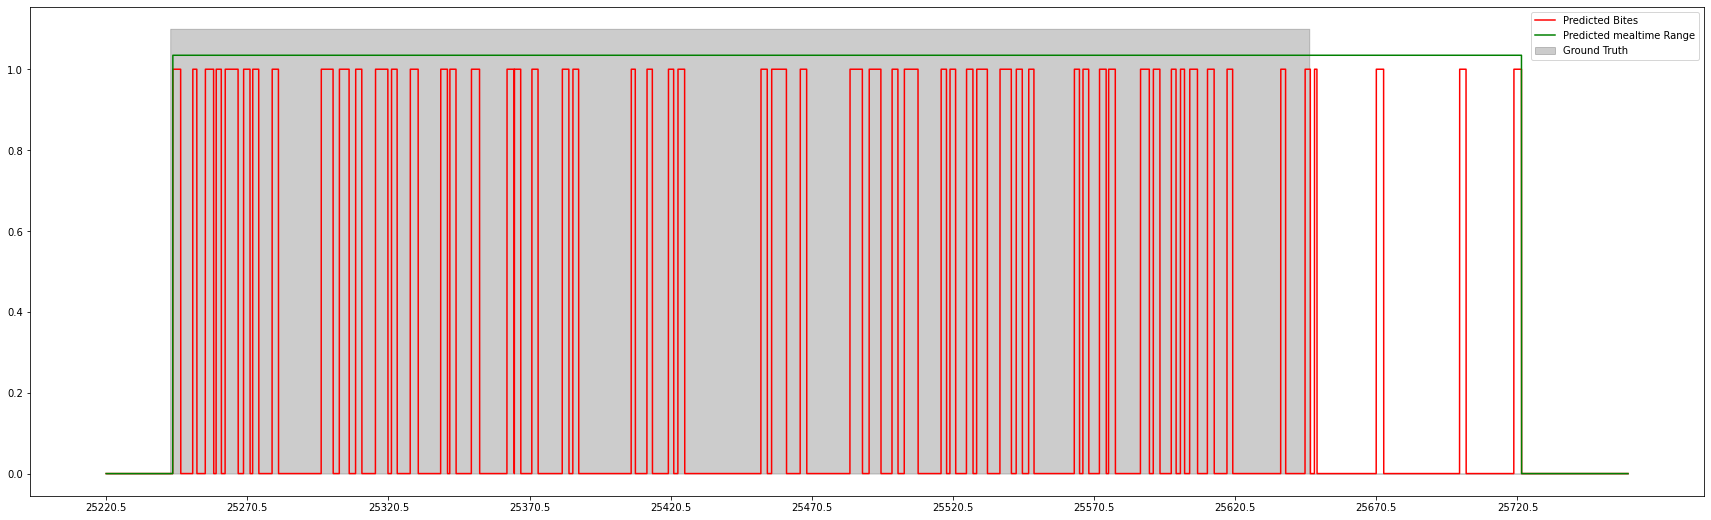

In [ ]:
result_FinalBackUP=result_Final
print(len(time_list),len(result_afterThreshold_list))
# strat =0
# end=-1
strat =538000
end= strat +11500
print(time_list[strat])
print(time_list[end])
ax = plt.figure(figsize=(30, 9))
indexList = list(range(strat,len(time_list),1))


my_x_ticks = np.arange(time_list[strat], time_list[end], 50)
# my_x_ticks = np.arange(indexList[strat], indexList[len(indexList)-1], 500)
gt_begin1 = min(annoList[validationPersonId1][:,0])
gt_end1 = max(annoList[validationPersonId1][:,1])
gt_begin2 = min(annoList[validationPersonId2][:,0])
gt_end2 = max(annoList[validationPersonId2][:,1])
gt_list = [0]*len(time_list)
for index in range(len(time_list[strat:end])):
  index = strat+ index
  timeStamp =  time_list[index] 
  if timeStamp> gt_begin1 and  timeStamp< gt_end1:
   gt_list[index]=1.1
  if timeStamp> gt_begin2 and  timeStamp< gt_end2:
   gt_list[index]=1.1



plt.xticks(my_x_ticks)

# plt.plot(time_list[strat:end],result_Final[strat:end],color='red',label= 'Predicted Bites' ,zorder=1)
# plt.plot(time_list[strat:end],result_Final_closing[strat:end],color='green',label= 'Predicted mealtime Range', zorder=2)
plt.plot(time_list[strat:end],result_Final[strat:end],color='red',label= 'Predicted Bites' ,zorder=1)
plt.plot(time_list[strat:end],result_Final_closing[strat:end],color='green',label= 'Predicted mealtime Range', zorder=2)
plt.fill_between(time_array[strat:end],gt_list[strat:end], interpolate=True, color='black', alpha=0.2,label= 'Ground Truth', zorder=1)

# time_list = array(time_list)
time_list = np.array(time_list)
print(type((time_list[strat:end])),time_list.shape)

plt.legend()
plt.show()

In [ ]:
begin = 0
end = 0 
print(len(time_list))
for oneElement in result_Final_closing:
  counter = counter+1
  if oneElement==1 and flag==0:
    flag=1
    begin=counter
  if oneElement ==0 and flag==1:
    flag=0
    end=counter
    print(end)
    # if time_list[end] - time_list[begin] > 300 :
    print(begin,end,time_list[begin],time_list[end])
    num = getTPNumber(begin,end)
    print(num,num/(end-begin))
    resultList.append( [time_list[begin],time_list[end],num,num/(end-begin)] )


803000
824671


IndexError: ignored

In [ ]:
resultList = np.array(resultSavedList)
print(resultList[0])
personRecall =  list()
personPrecision =  list()
personF1 =  list()
PersonId=list()
FinalResultGraph = list()
for eachMeal in resultList:
  personRecall.append(eachMeal[3]) 
  personPrecision.append(eachMeal[4]) 
  personF1.append(eachMeal[5])
  PersonId.append(eachMeal[0])

  FinalResultGraph.append([eachMeal[0],eachMeal[3],eachMeal[4],eachMeal[5],eachMeal[2]])
  

[0, 0, array([0.9989312], dtype=float32), 0.8873239436619719, 0.863013698630137, 0.875]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [ ]:
FinalResultGraph.sort() 
FinalResultGraph=np.array(FinalResultGraph)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [ ]:
FinalResultGraph[:,0]=(FinalResultGraph[:,0]).astype(np.int32)
print( (FinalResultGraph[:,0]).astype(np.int32) )


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 32 33 34 35 36 37 39 40 41 42 43 44 45 46 47]


Mean IOU is: [0.9093898] Mean F1 is: 0.88141592920354


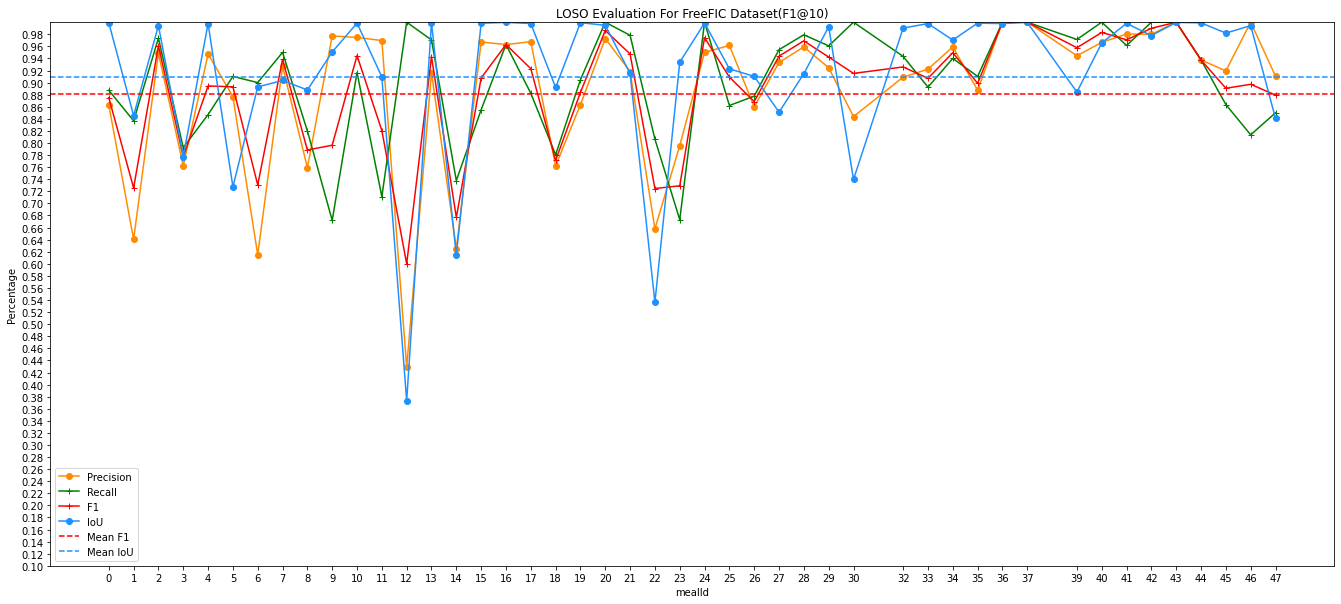

46 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 32 33 34 35 36 37 39 40 41 42 43 44 45 46 47]


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

print("Mean IOU is:",totalIOU,"Mean F1 is:",totalF1)
# personId=range(0,46,1)
personId=(FinalResultGraph[:,0]).astype(np.int32) 

plt.figure(figsize=(23, 10))
# my_x_ticks = np.arange(0,42,1)
my_x_ticks = PersonId
plt.xticks(my_x_ticks)

my_y_ticks = np.arange(0,1,0.02)
plt.yticks(my_y_ticks)
ax = plt.gca()
ax.set_ylim([0.1, 1])

personRecall=FinalResultGraph[:,1]
personPrecision=FinalResultGraph[:,2]
personF1=FinalResultGraph[:,3]
personIOU=FinalResultGraph[:,4]

# print(personId)
# l1=plt.plot(personId,personPrecision,'c-',label= 'Precision')
# l2=plt.plot(personId,personRecall,'g-',label='Recall')
# l3=plt.plot(personId,personF1,'r-',label='F1')
# l3=plt.plot(personId,personIOU,'c-',label='IoU')



l1=plt.plot(personId,personPrecision,color='darkorange', linestyle='-', marker='o',label= 'Precision')
l2=plt.plot(personId,personRecall,color='green', linestyle='-', marker='+',label='Recall')

l3=plt.plot(personId,personF1,color='red', linestyle='-', marker='+',label='F1')
l4=plt.plot(personId,personIOU,color='dodgerblue', linestyle='-', marker='o',label='IoU')

l5=plt.axhline(y=totalF1, color='r', linestyle='--',label='Mean F1')
l6=plt.axhline(y=totalIOU, color='dodgerblue', linestyle='--',label='Mean IoU')

# plt.xticks(range(48),(personId))
# print(personId)


plt.title('LOSO Evaluation For FreeFIC Dataset(F1@10)')
plt.xlabel('mealId')
plt.ylabel('Percentage')
plt.legend()
plt.show()

print(len(personId),personId)



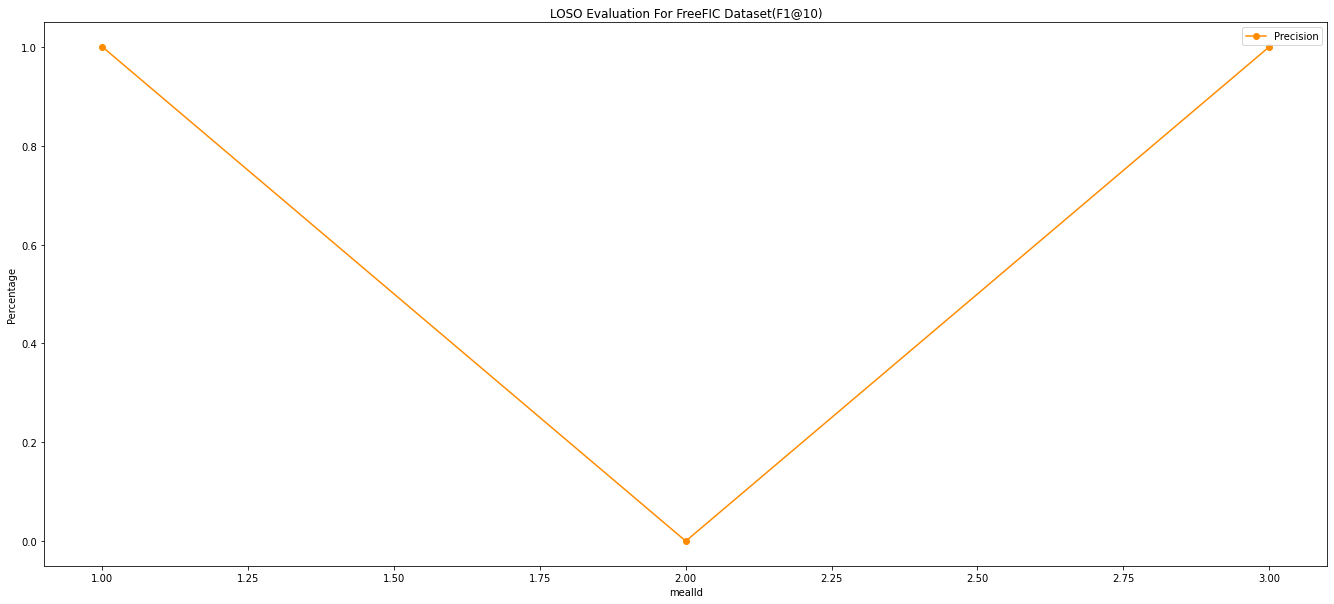

In [ ]:
plt.figure(figsize=(23, 10))

xlist=[1,2,3]
ylist=[1,0,1]

l1=plt.plot(xlist,ylist,color='darkorange', linestyle='-', marker='o',label= 'Precision')

# plt.xticks(range(3),(xlist))
# print(personId)


plt.title('LOSO Evaluation For FreeFIC Dataset(F1@10)')
plt.xlabel('mealId')
plt.ylabel('Percentage')
plt.legend()
plt.show()

No handles with labels found to put in legend.


Mean IOU is: [0.90869415] Mean F1 is: 0.8809289509938989
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 44, 45, 28, 29, 30, 40, 41, 32, 33, 34, 35, 36, 37, 42, 43, 39, 46, 47]


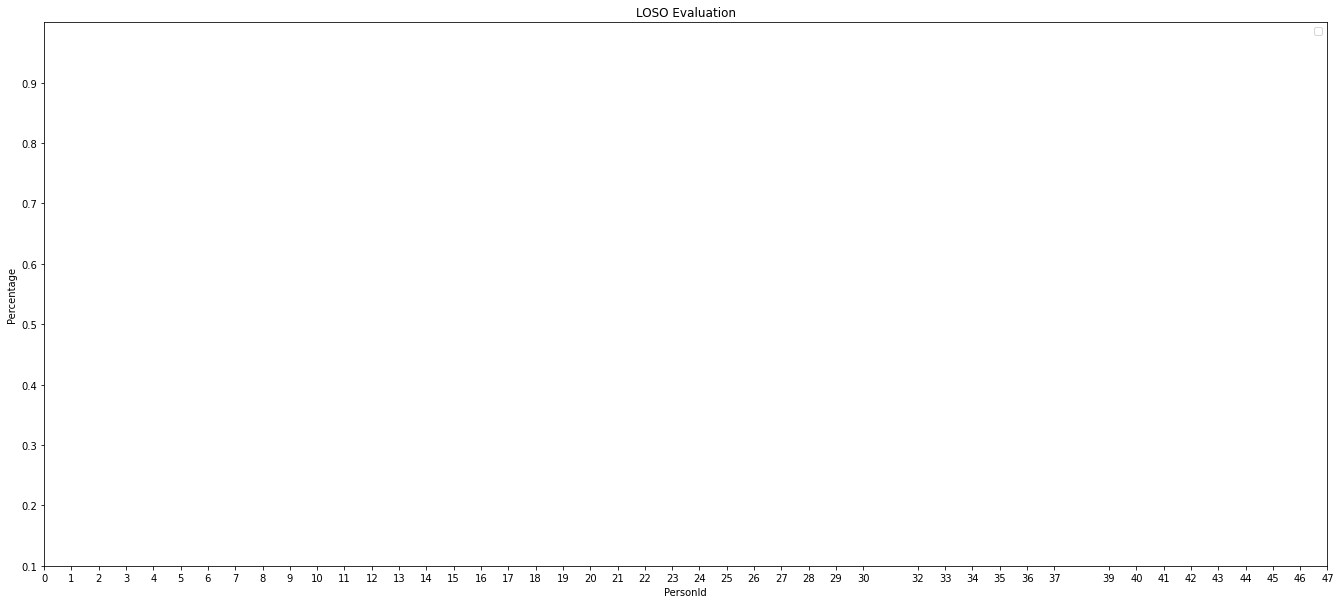

In [ ]:
import matplotlib.pyplot as plt
print("Mean IOU is:",totalIOU,"Mean F1 is:",totalF1)
# personId=range(0,46,1)
# personId=PersonId
plt.figure(figsize=(23, 10))
# my_x_ticks = np.arange(0,46,1)
my_x_ticks = PersonId
print(PersonId)
plt.xticks(my_x_ticks)

my_y_ticks = np.arange(0,1,0.1)
plt.yticks(my_y_ticks)
ax = plt.gca()
ax.set_ylim([0.1, 1])


ax.set_xticklabels(my_x_ticks)


plt.title('LOSO Evaluation')
plt.xlabel('PersonId')
plt.ylabel('Percentage')
plt.legend()
plt.show()




In [ ]:
print(annoList[42])